In [86]:
import numpy as np 
from scipy import misc  
from PIL import Image  
import glob  
import matplotlib.pyplot as plt  
import scipy.misc  
from matplotlib.pyplot import imshow  
%matplotlib inline
from IPython.display import SVG  
import cv2  
import seaborn as sn  
import pandas as pd  
import pickle  
from keras import layers  
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout  
from keras.models import Sequential, Model, load_model  
from keras.preprocessing import image  
from keras.preprocessing.image import load_img  
from keras.preprocessing.image import img_to_array  
from keras.applications.imagenet_utils import decode_predictions  
from keras.utils import layer_utils, np_utils  
from keras.utils.data_utils import get_file  
from keras.applications.imagenet_utils import preprocess_input  
from keras.utils.vis_utils import model_to_dot  
from keras.utils import plot_model  
from keras.initializers import glorot_uniform  
from keras import losses  
import keras.backend as K  
from keras.callbacks import ModelCheckpoint  
from sklearn.metrics import confusion_matrix, classification_report  
import tensorflow as tf 

In [87]:
from keras.datasets import cifar100

(x_train_original, y_train_original), (x_test_original, y_test_original) = cifar100.load_data(label_mode='fine')

In [88]:
y_train = np_utils.to_categorical(y_train_original, 100)
y_test = np_utils.to_categorical(y_test_original, 100)

In [89]:
x_train = x_train_original/255  
x_test = x_test_original/255

In [90]:
import numpy as np
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs

In [91]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
  
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [92]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
   
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [93]:
def CustomResNet50(include_top=True, input_tensor=None, input_shape=(32,32,3), pooling=None, classes=100):
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D(padding=(2, 2), name='conv1_pad')(img_input)

    x = conv_block(x, 3, [32, 32, 64], stage=2, block='a')
    x = identity_block(x, 3, [32, 32, 64], stage=2, block='b')
    x = identity_block(x, 3, [32, 32, 64], stage=2, block='c')

    x = conv_block(x, 3, [64, 64, 256], stage=3, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=3, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=3, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=4, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=5, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=5, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=5, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=5, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=5, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=5, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=6, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=6, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=6, block='c')

    x = AveragePooling2D((1, 1), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [94]:
def create_custom_resnet50():  
    model = CustomResNet50(include_top=True, input_tensor=None, input_shape=(32,32,3), pooling=None, classes=100)

    return model

custom_resnet50_model = create_custom_resnet50()  
custom_resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])  

In [95]:
custom_resnet50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 36, 36, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
res2a_branch2a (Conv2D)         (None, 18, 18, 32)   128         conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn2a_branch2a (BatchNormalizati (None, 18, 18, 32)   128         res2a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

flatten_5 (Flatten)             (None, 18432)        0           avg_pool[0][0]                   
__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 100)          1843300     flatten_5[0][0]                  
Total params: 25,461,700
Trainable params: 25,407,812
Non-trainable params: 53,888
__________________________________________________________________________________________________


In [96]:
crn50 = custom_resnet50_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 359s 7ms/step - loss: 4.6570 - acc: 0.0757 - mean_squared_error: 0.0102 - val_loss: 3.9518 - val_acc: 0.1410 - val_mean_squared_error: 0.0096
Epoch 2/10
50000/50000 [==============================] - 315s 6ms/step - loss: 3.9827 - acc: 0.1586 - mean_squared_error: 0.0096 - val_loss: 13.7041 - val_acc: 0.0151 - val_mean_squared_error: 0.0178
Epoch 3/10
37280/50000 [=====================>........] - ETA: 1:16 - loss: 4.3480 - acc: 0.1217 - mean_squared_error: 0.0099

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Valken\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-6ba22870bd2e>", line 1, in <module>
    crn50 = custom_resnet50_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=True)
  File "C:\Users\Valken\Anaconda3\lib\site-packages\keras\engine\training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "C:\Users\Valken\Anaconda3\lib\site-packages\keras\engine\training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "C:\Users\Valken\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "C:\Users\Valken\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_fn(*array_vals)
  File "C:\Users\Valken\Anac

KeyboardInterrupt: 

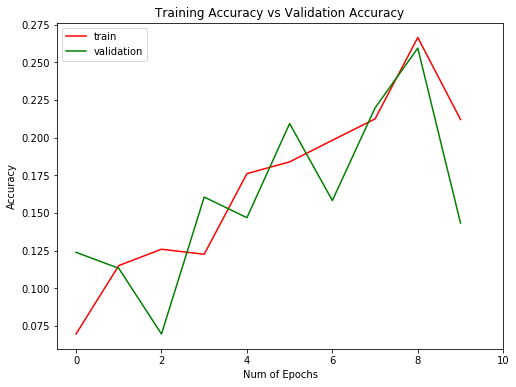

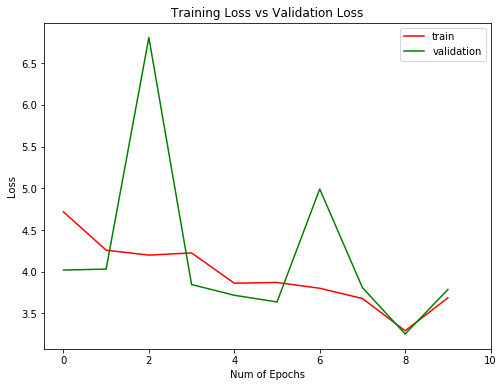

In [47]:
plt.figure(0)  
plt.plot(crn50.history['acc'],'r')  
plt.plot(crn50.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(crn50.history['loss'],'r')  
plt.plot(crn50.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

10000/10000 [==============================] - 19s 2ms/step


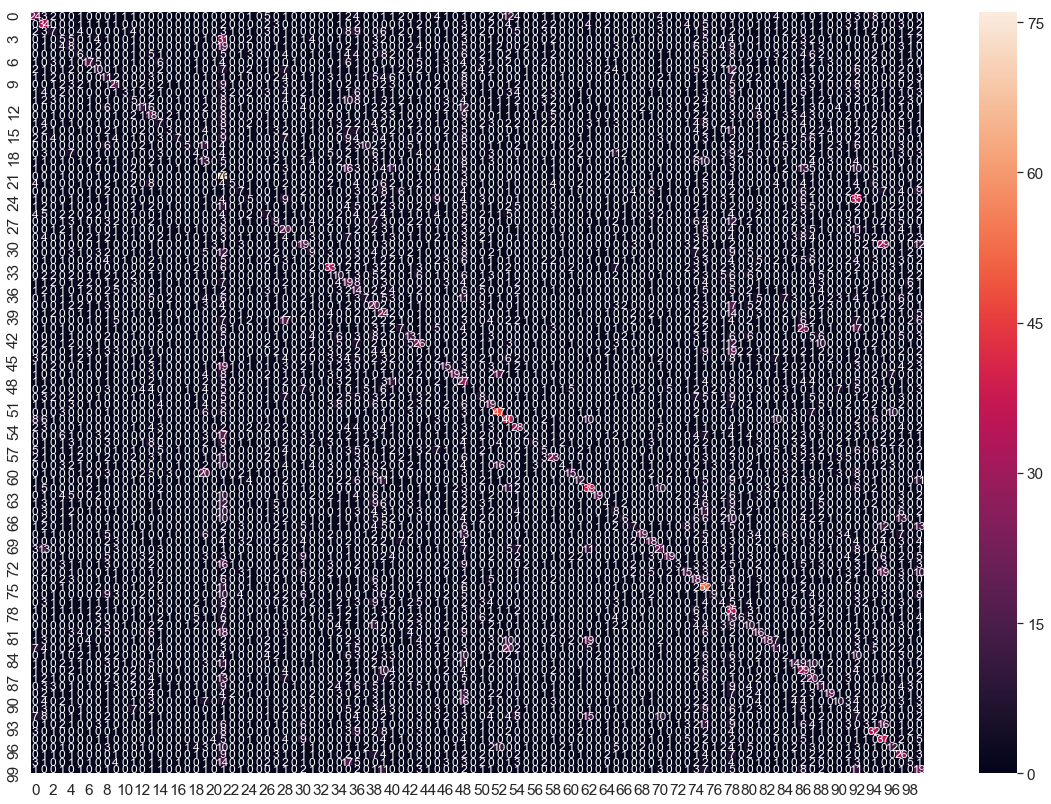

In [48]:
crn50_pred = custom_resnet50_model.predict(x_test, batch_size=32, verbose=1)  
crn50_predicted = np.argmax(crn50_pred, axis=1)

crn50_cm = confusion_matrix(np.argmax(y_test, axis=1), crn50_predicted)

# Visualizing of confusion matrix
crn50_df_cm = pd.DataFrame(crn50_cm, range(100), range(100))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(crn50_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [49]:
crn50_report = classification_report(np.argmax(y_test, axis=1), crn50_predicted)  
print(crn50_report)

              precision    recall  f1-score   support

           0       0.22      0.24      0.23       100
           1       0.20      0.34      0.25       100
           2       0.14      0.07      0.09       100
           3       0.07      0.05      0.06       100
           4       0.08      0.08      0.08       100
           5       0.11      0.06      0.08       100
           6       0.26      0.17      0.21       100
           7       0.15      0.10      0.12       100
           8       0.08      0.11      0.09       100
           9       0.25      0.21      0.23       100
          10       0.38      0.03      0.06       100
          11       0.07      0.05      0.06       100
          12       0.31      0.11      0.16       100
          13       0.12      0.18      0.15       100
          14       0.08      0.07      0.07       100
          15       0.14      0.03      0.05       100
          16       0.35      0.07      0.12       100
          17       0.50    

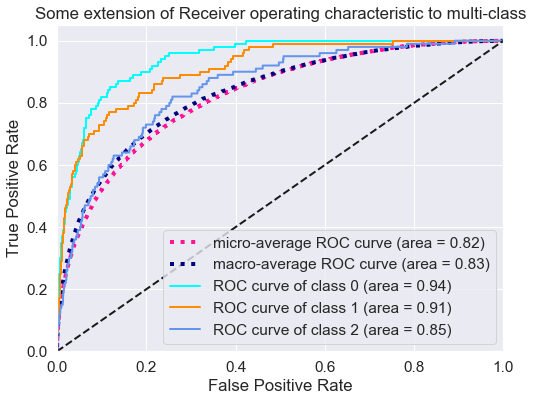

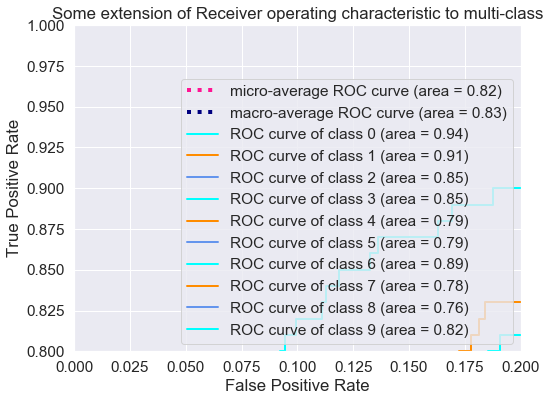

In [50]:
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

n_classes = 100

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], crn50_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), crn50_pred.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(n_classes-97), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(10), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()  

In [51]:
#Modelo
custom_resnet50_model.save('crn50.h5')

#Histórico
with open('crn50_history.txt', 'wb') as file_pi:  
  pickle.dump(crn50.history, file_pi)

In [33]:
with open('cvgg16_history.txt', 'rb') as f:  
  vgg16Bis_history = pickle.load(f)

In [24]:
with open('vgg19_history.txt', 'rb') as f:  
  vgg19.history = pickle.load(f)

In [25]:
with open('vgg16_history.txt', 'rb') as f:  
  vgg16.history = pickle.load(f)

In [26]:
with open('simplenn_history.txt', 'rb') as f:  
  snn.history = pickle.load(f)

In [27]:
with open('scnn_history.txt', 'rb') as f:  
  scnn.history = pickle.load(f)

In [28]:
with open('crn50_history.txt', 'rb') as f:  
  crn50.history = pickle.load(f)

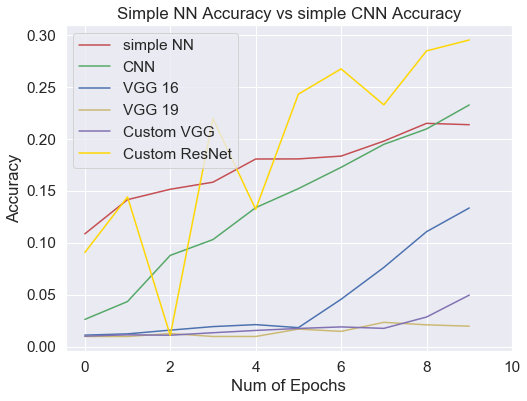

In [52]:
plt.figure(0)  
plt.plot(snn_history['val_acc'],'r')  
plt.plot(scnn_history['val_acc'],'g')  
plt.plot(vgg16_history['val_acc'],'b')  
plt.plot(vgg19_history['val_acc'],'y')  
plt.plot(vgg16Bis_history['val_acc'],'m')  
plt.plot(crn50_history['val_acc'],'gold')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Simple NN Accuracy vs simple CNN Accuracy")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19','Custom VGG','Custom ResNet'])  

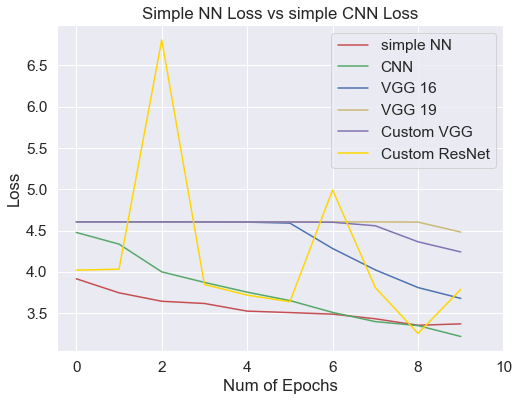

In [56]:
plt.figure(0)  
plt.plot(snn_history['val_loss'],'r')  
plt.plot(scnn_history['val_loss'],'g')  
plt.plot(vgg16_history['val_loss'],'b')  
plt.plot(vgg19_history['val_loss'],'y')  
plt.plot(vgg16Bis_history['val_loss'],'m')  
plt.plot(crn50.history['val_loss'],'gold')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Simple NN Loss vs simple CNN Loss")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19','Custom VGG','Custom ResNet'])  

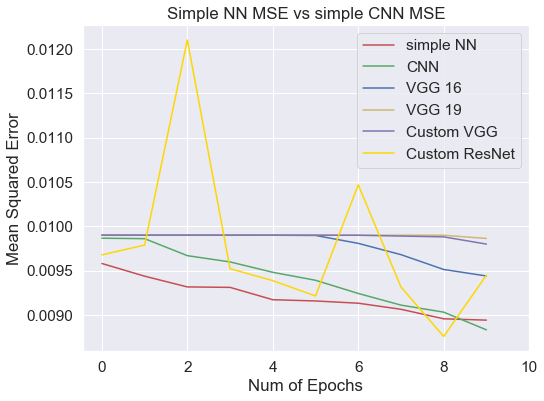

In [55]:
plt.figure(0)  
plt.plot(snn_history['val_mean_squared_error'],'r')  
plt.plot(scnn_history['val_mean_squared_error'],'g')  
plt.plot(vgg16_history['val_mean_squared_error'],'b')  
plt.plot(vgg19_history['val_mean_squared_error'],'y')  
plt.plot(vgg16Bis_history['val_mean_squared_error'],'m')  
plt.plot(crn50.history['val_mean_squared_error'],'gold')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Mean Squared Error")  
plt.title("Simple NN MSE vs simple CNN MSE")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19','Custom VGG','Custom ResNet'])  